In [31]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.mixture import GaussianMixture

# 1. Two-dimensional data with bottleneck

In [3]:
def generate_moons(size, noise = 0.1, seed = 0):
    np.random.seed(seed)
    return make_moons(n_samples=size, noise = noise)[0]

## 1.1 Define Autoencoder

In [23]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()

        self.criterion = nn.MSELoss()

        # Encoder
        encoder_layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        for _ in range(layers - 1):
            encoder_layers.append(nn.Linear(hidden_size, hidden_size))
            encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = [nn.Linear(bottleneck_size, hidden_size), nn.ReLU()]
        for _ in range(layers - 1):
            decoder_layers.append(nn.Linear(hidden_size, hidden_size))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(hidden_size, input_size))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def return_code(self, x):
        return self.encoder(x)
    
    def generate(self, x):
        return self.decoder(x)


In [9]:
def train_autoencoder(model, training_size, epochs, lr = 0.001, seed = None, batch_size = 100, test_size = 1000): 
    
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_dataloader = DataLoader(
        dataset = TensorDataset(torch.tensor(generate_moons(training_size, seed = seed)).float()),
        batch_size = batch_size,
        shuffle = True,
        num_workers=1,
        pin_memory=True
    )    

    test_dataloader = DataLoader(
        dataset = TensorDataset(torch.tensor(generate_moons(test_size)).float()),
        batch_size = batch_size,
        shuffle = False,
        num_workers=1,
        pin_memory=True
    )

    train_loss = []
    test_loss = []

    test_points = []
    reconstructed_points = []

    for epoch in range(epochs + 1):
        train_loss_this_epoch = []
        for batch in train_dataloader:
            reconstructed = model.forward(batch[0])
            loss = model.criterion(reconstructed, batch[0])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_this_epoch.append(float(loss))

        train_loss.append(np.mean(train_loss_this_epoch))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}")
            print(f"Mean Train Loss {train_loss[-1]:.2e}")
            test_loss_this_epoch = []
            test_points_this_epoch = np.zeros((0, 2))
            reconstructed_points_this_epoch = np.zeros((0, 2))

            for batch in test_dataloader:
                with torch.no_grad():
                    reconstructed = model.forward(batch[0])
                    loss = model.criterion(reconstructed, batch[0])
                    test_loss_this_epoch.append(float(loss))

                    test_points_this_epoch = np.concatenate([test_points_this_epoch, batch[0].numpy()], axis=0)
                    reconstructed_points_this_epoch = np.concatenate([reconstructed_points_this_epoch, reconstructed.numpy()], axis=0)

            test_loss.append(np.mean(test_loss_this_epoch))
            test_points.append(test_points_this_epoch)
            reconstructed_points.append(reconstructed_points_this_epoch)

            print(f"Mean Test Loss {test_loss[-1]:.2e}")

    return train_loss, test_loss, test_points, reconstructed_points

## 1.2 Hyperparameters

In [34]:
test_size = 1000
batch_size = 100
hidden_size_ = [3, 5, 8, 12]
layers_ = [1, 2, 3, 4, 6, 10]
training_size_ = [100, 1000, 10000, 100000, 1000000]
epochs_ = [10, 50, 100, 200]
lr_ = [0.001, 0.01, 0.1]

In [ ]:
hidden_size_results = np.zeros((len(hidden_size_), 4), dtype = object)
for i, hidden_size in enumerate(hidden_size_):
    model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=hidden_size, layers=2)
    train_loss, test_loss, test_points, reconstructed_points = train_autoencoder(model, training_size=5000, epochs=50, lr=0.001)
    hidden_size_results[i, :] = [train_loss, test_loss, test_points, reconstructed_points]

In [63]:
layers_results = np.zeros((len(layers_), 4), dtype = object)
for i, layers in enumerate(layers_):
    model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=8, layers=layers)
    train_loss, test_loss, test_points, reconstructed_points = train_autoencoder(model, training_size=5000, epochs=50, lr=0.001)
    layers_results[i, :] = [train_loss, test_loss, test_points, reconstructed_points]

Epoch 0
Mean Train Loss 5.33e-01
Mean Test Loss 4.80e-01
Epoch 10
Mean Train Loss 8.70e-02
Mean Test Loss 8.55e-02
Epoch 20
Mean Train Loss 6.94e-02
Mean Test Loss 6.81e-02
Epoch 30
Mean Train Loss 6.16e-02
Mean Test Loss 6.02e-02
Epoch 40
Mean Train Loss 5.84e-02
Mean Test Loss 5.70e-02
Epoch 50
Mean Train Loss 5.58e-02
Mean Test Loss 5.44e-02
Epoch 0
Mean Train Loss 6.99e-01
Mean Test Loss 6.30e-01
Epoch 10
Mean Train Loss 1.01e-01
Mean Test Loss 9.76e-02
Epoch 20
Mean Train Loss 7.38e-02
Mean Test Loss 7.23e-02
Epoch 30
Mean Train Loss 5.64e-02
Mean Test Loss 5.47e-02
Epoch 40
Mean Train Loss 4.31e-02
Mean Test Loss 4.18e-02
Epoch 50
Mean Train Loss 3.74e-02
Mean Test Loss 3.63e-02
Epoch 0
Mean Train Loss 9.14e-01
Mean Test Loss 8.07e-01
Epoch 10
Mean Train Loss 7.81e-02
Mean Test Loss 7.48e-02
Epoch 20
Mean Train Loss 5.74e-02
Mean Test Loss 5.52e-02
Epoch 30
Mean Train Loss 4.97e-02
Mean Test Loss 4.86e-02
Epoch 40
Mean Train Loss 4.53e-02
Mean Test Loss 4.36e-02
Epoch 50
Mean Tra

In [67]:
training_size_results = np.zeros((len(training_size_), 4), dtype = object)
for i, size in enumerate(training_size_):
    model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=8, layers=2)
    train_loss, test_loss, test_points, reconstructed_points = train_autoencoder(model, training_size=size, epochs=50, lr=0.001)
    training_size_results[i, :] = [train_loss, test_loss, test_points, reconstructed_points]

Epoch 0
Mean Train Loss 6.56e-01
Mean Test Loss 6.50e-01
Epoch 10
Mean Train Loss 6.38e-01
Mean Test Loss 6.32e-01
Epoch 20
Mean Train Loss 6.21e-01
Mean Test Loss 6.14e-01
Epoch 30
Mean Train Loss 6.04e-01
Mean Test Loss 5.97e-01
Epoch 40
Mean Train Loss 5.87e-01
Mean Test Loss 5.80e-01
Epoch 50
Mean Train Loss 5.70e-01
Mean Test Loss 5.63e-01
Epoch 0
Mean Train Loss 6.98e-01
Mean Test Loss 6.74e-01
Epoch 10
Mean Train Loss 5.24e-01
Mean Test Loss 5.20e-01
Epoch 20
Mean Train Loss 3.63e-01
Mean Test Loss 3.47e-01
Epoch 30
Mean Train Loss 1.38e-01
Mean Test Loss 1.34e-01
Epoch 40
Mean Train Loss 9.61e-02
Mean Test Loss 9.53e-02
Epoch 50
Mean Train Loss 8.62e-02
Mean Test Loss 8.62e-02
Epoch 0
Mean Train Loss 6.09e-01
Mean Test Loss 4.46e-01
Epoch 10
Mean Train Loss 7.86e-02
Mean Test Loss 7.84e-02
Epoch 20
Mean Train Loss 4.45e-02
Mean Test Loss 4.40e-02
Epoch 30
Mean Train Loss 4.14e-02
Mean Test Loss 4.16e-02
Epoch 40
Mean Train Loss 4.00e-02
Mean Test Loss 4.02e-02
Epoch 50
Mean Tra

In [71]:
lr_results = np.zeros((len(lr_), 4), dtype = object)
for i, lr in enumerate(lr_):
    model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=8, layers=2)
    train_loss, test_loss, test_points, reconstructed_points = train_autoencoder(model, training_size=10000, epochs=50, lr=lr)
    lr_results[i, :] = [train_loss, test_loss, test_points, reconstructed_points]

Epoch 0
Mean Train Loss 5.21e-01
Mean Test Loss 5.01e-01
Epoch 10
Mean Train Loss 5.98e-02
Mean Test Loss 5.33e-02
Epoch 20
Mean Train Loss 3.65e-02
Mean Test Loss 3.80e-02
Epoch 30
Mean Train Loss 3.22e-02
Mean Test Loss 3.33e-02
Epoch 40
Mean Train Loss 2.79e-02
Mean Test Loss 2.85e-02
Epoch 50
Mean Train Loss 2.41e-02
Mean Test Loss 2.46e-02
Epoch 0
Mean Train Loss 1.91e-01
Mean Test Loss 8.44e-02
Epoch 10
Mean Train Loss 2.20e-02
Mean Test Loss 1.93e-02
Epoch 20
Mean Train Loss 1.30e-02
Mean Test Loss 1.09e-02
Epoch 30
Mean Train Loss 1.01e-02
Mean Test Loss 8.87e-03
Epoch 40
Mean Train Loss 9.31e-03
Mean Test Loss 9.04e-03
Epoch 50
Mean Train Loss 1.20e-02
Mean Test Loss 1.97e-02
Epoch 0
Mean Train Loss 1.65e-01
Mean Test Loss 9.36e-02
Epoch 10
Mean Train Loss 9.01e-02
Mean Test Loss 8.85e-02
Epoch 20
Mean Train Loss 8.95e-02
Mean Test Loss 9.13e-02
Epoch 30
Mean Train Loss 9.06e-02
Mean Test Loss 1.05e-01
Epoch 40
Mean Train Loss 9.02e-02
Mean Test Loss 8.81e-02
Epoch 50
Mean Tra

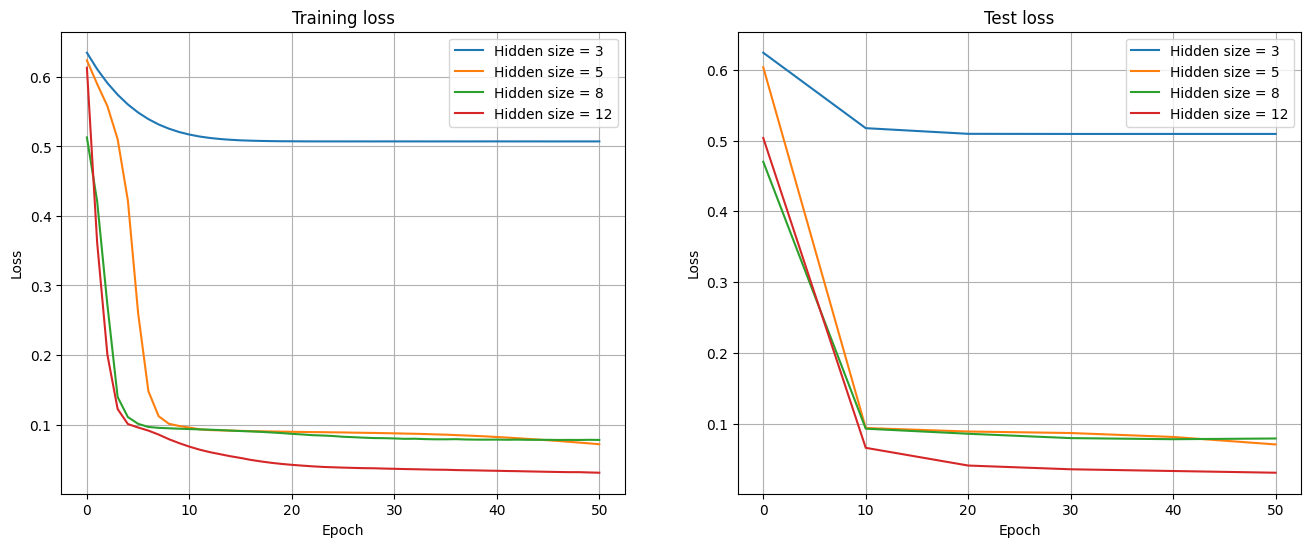

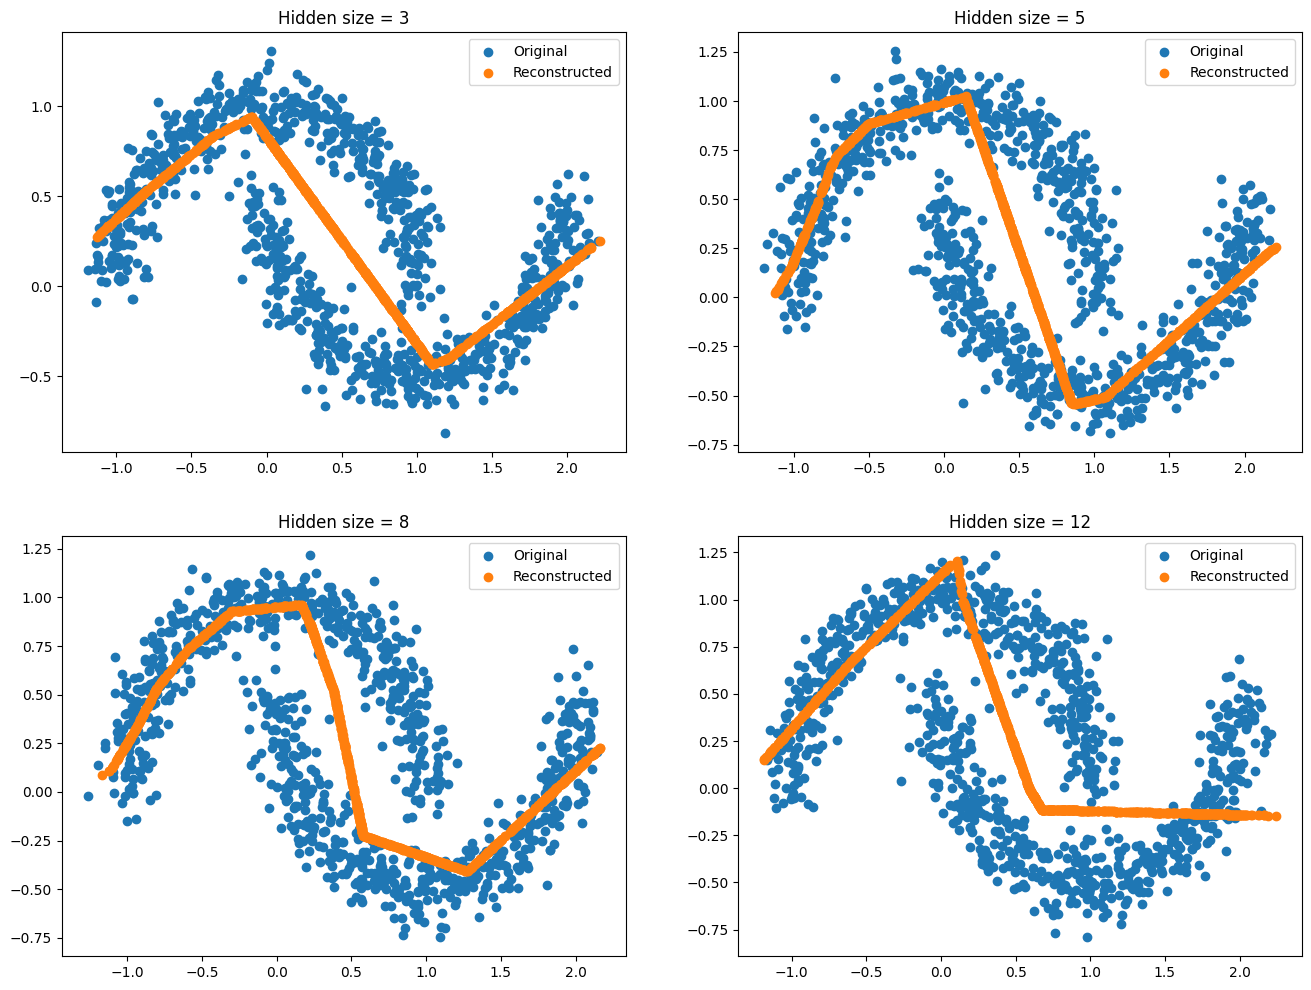

In [98]:
train_range = np.linspace(0, 50, 51)
test_range = np.linspace(0, 50, 6)

plt.figure(figsize=(16, 6))
for i in range(len(hidden_size_)):
    plt.subplot(1, 2, 1)
    plt.plot(train_range, hidden_size_results[i,:][0], label = f"Hidden size = {hidden_size_[i]}")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.grid()

for i in range(len(hidden_size_)):
    plt.subplot(1, 2, 2)
    plt.plot(test_range, hidden_size_results[i,:][1], label = f"Hidden size = {hidden_size_[i]}")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test loss")
plt.grid()
plt.show()

plt.figure(figsize=(16, 12))
for i, size in enumerate(hidden_size_):
    plt.subplot(2, 2, i + 1)
    plt.scatter(layers_results[i,:][2][-1][:,0], layers_results[i,:][2][-1][:,1], label = "Original")
    plt.scatter(layers_results[i,:][3][-1][:,0], layers_results[i,:][3][-1][:,1], label = f"Reconstructed")
    plt.title(f"Hidden size = {size}")
    plt.legend()
plt.show()

A larger dimension of the hidden layers improves the performance of the model. It might be that the training size was to small to train hidden layers with size 12. This could explain why the reconstructed data for size = 12 looks worse than for smaller sizes.

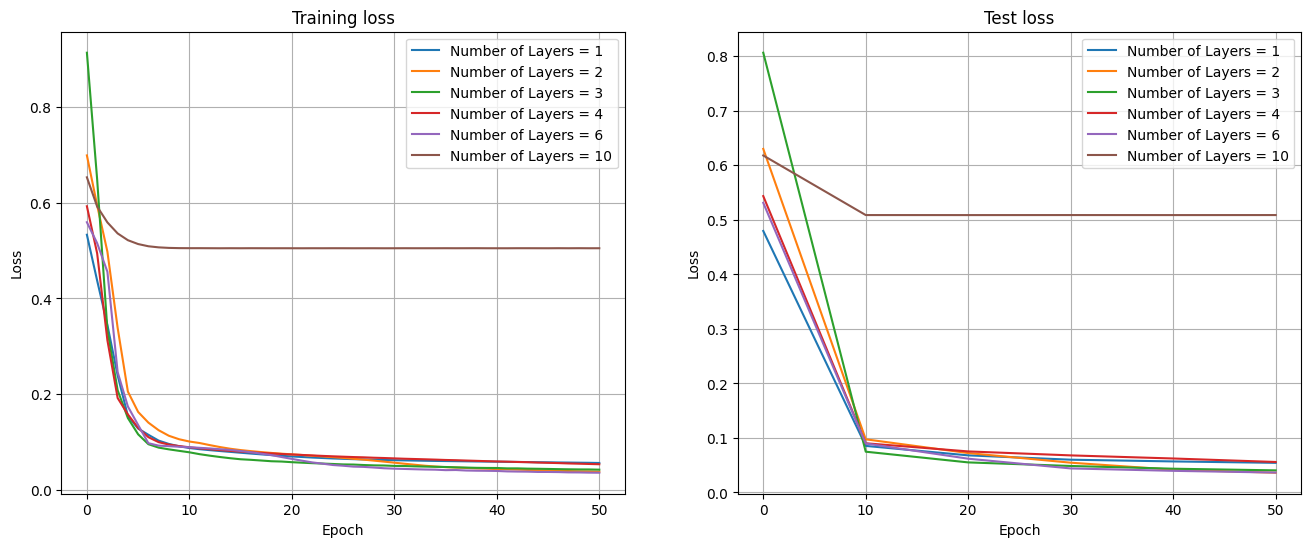

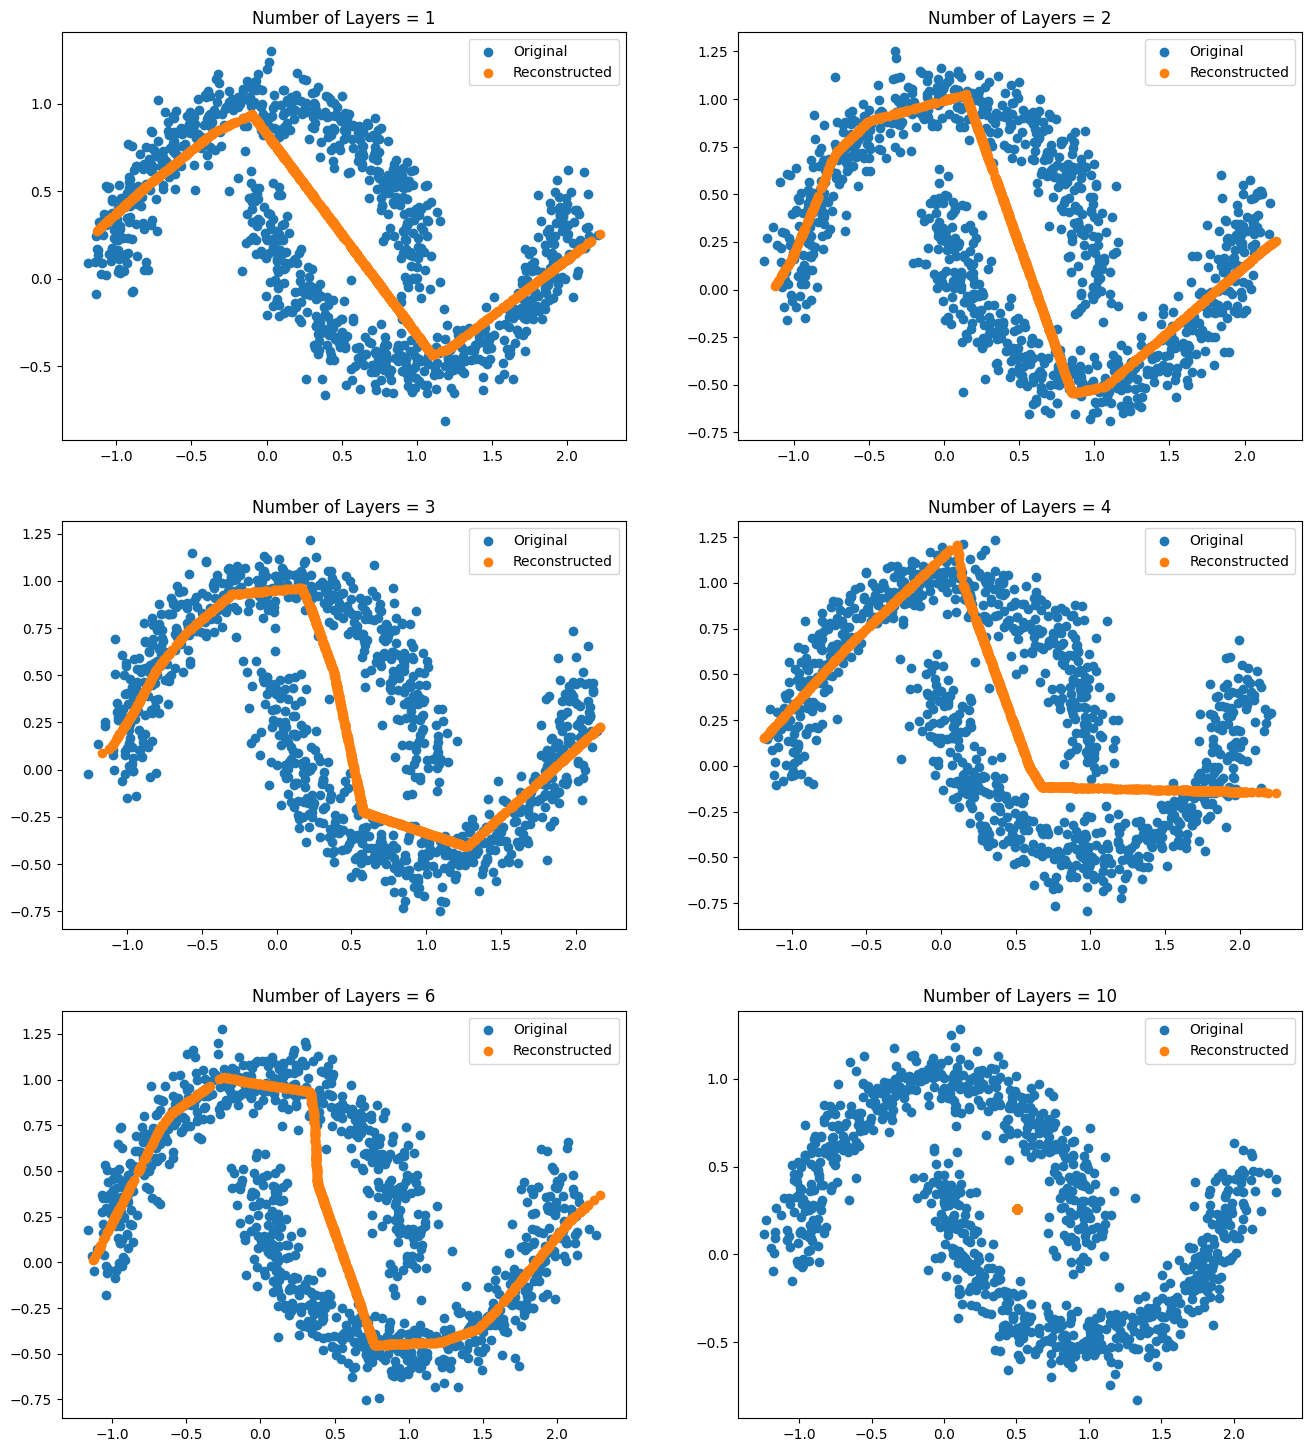

In [101]:
train_range = np.linspace(0, 50, 51)
test_range = np.linspace(0, 50, 6)

plt.figure(figsize=(16, 6))
for i in range(len(layers_)):
    plt.subplot(1, 2, 1)
    plt.plot(train_range, layers_results[i,:][0], label = f"Number of Layers = {layers_[i]}")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.grid()

for i in range(len(layers_)):
    plt.subplot(1, 2, 2)
    plt.plot(test_range, layers_results[i,:][1], label = f"Number of Layers = {layers_[i]}")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test loss")
plt.grid()
plt.show()

plt.figure(figsize=(16, 18))
for i, size in enumerate(layers_):
    plt.subplot(3, 2, i + 1)
    plt.scatter(layers_results[i,:][2][-1][:,0], layers_results[i,:][2][-1][:,1], label = "Original")
    plt.scatter(layers_results[i,:][3][-1][:,0], layers_results[i,:][3][-1][:,1], label = f"Reconstructed")
    plt.title(f"Number of Layers = {size}")
    plt.legend()
plt.show()

More hidden layers improve the performance of the model. However, the effect is not too big. For 10 layers, the training set was proabably too small again.

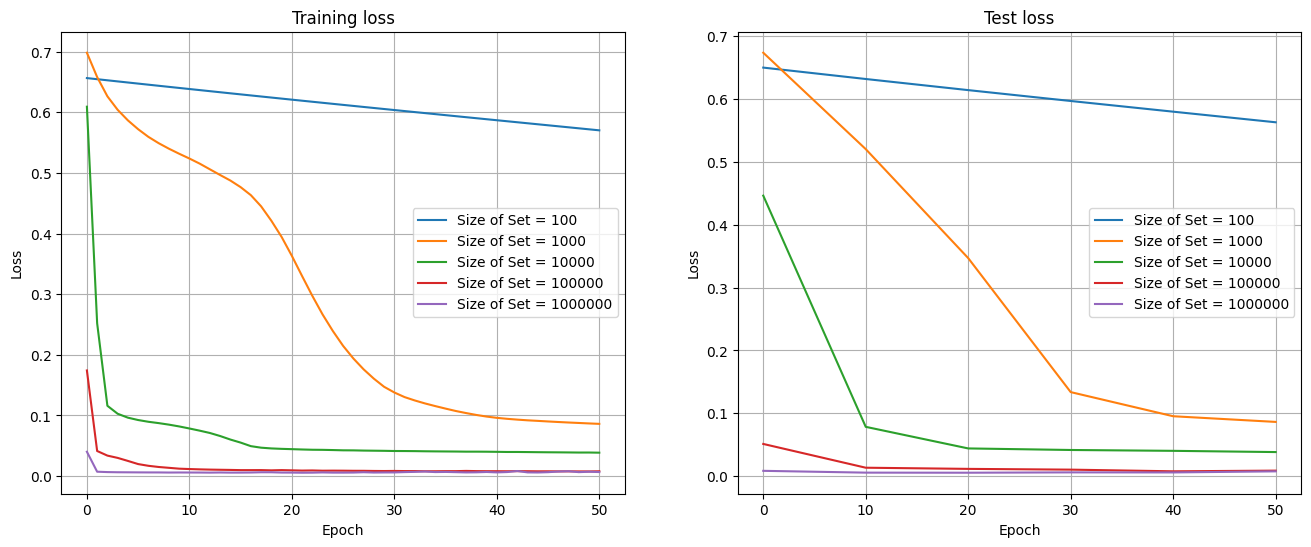

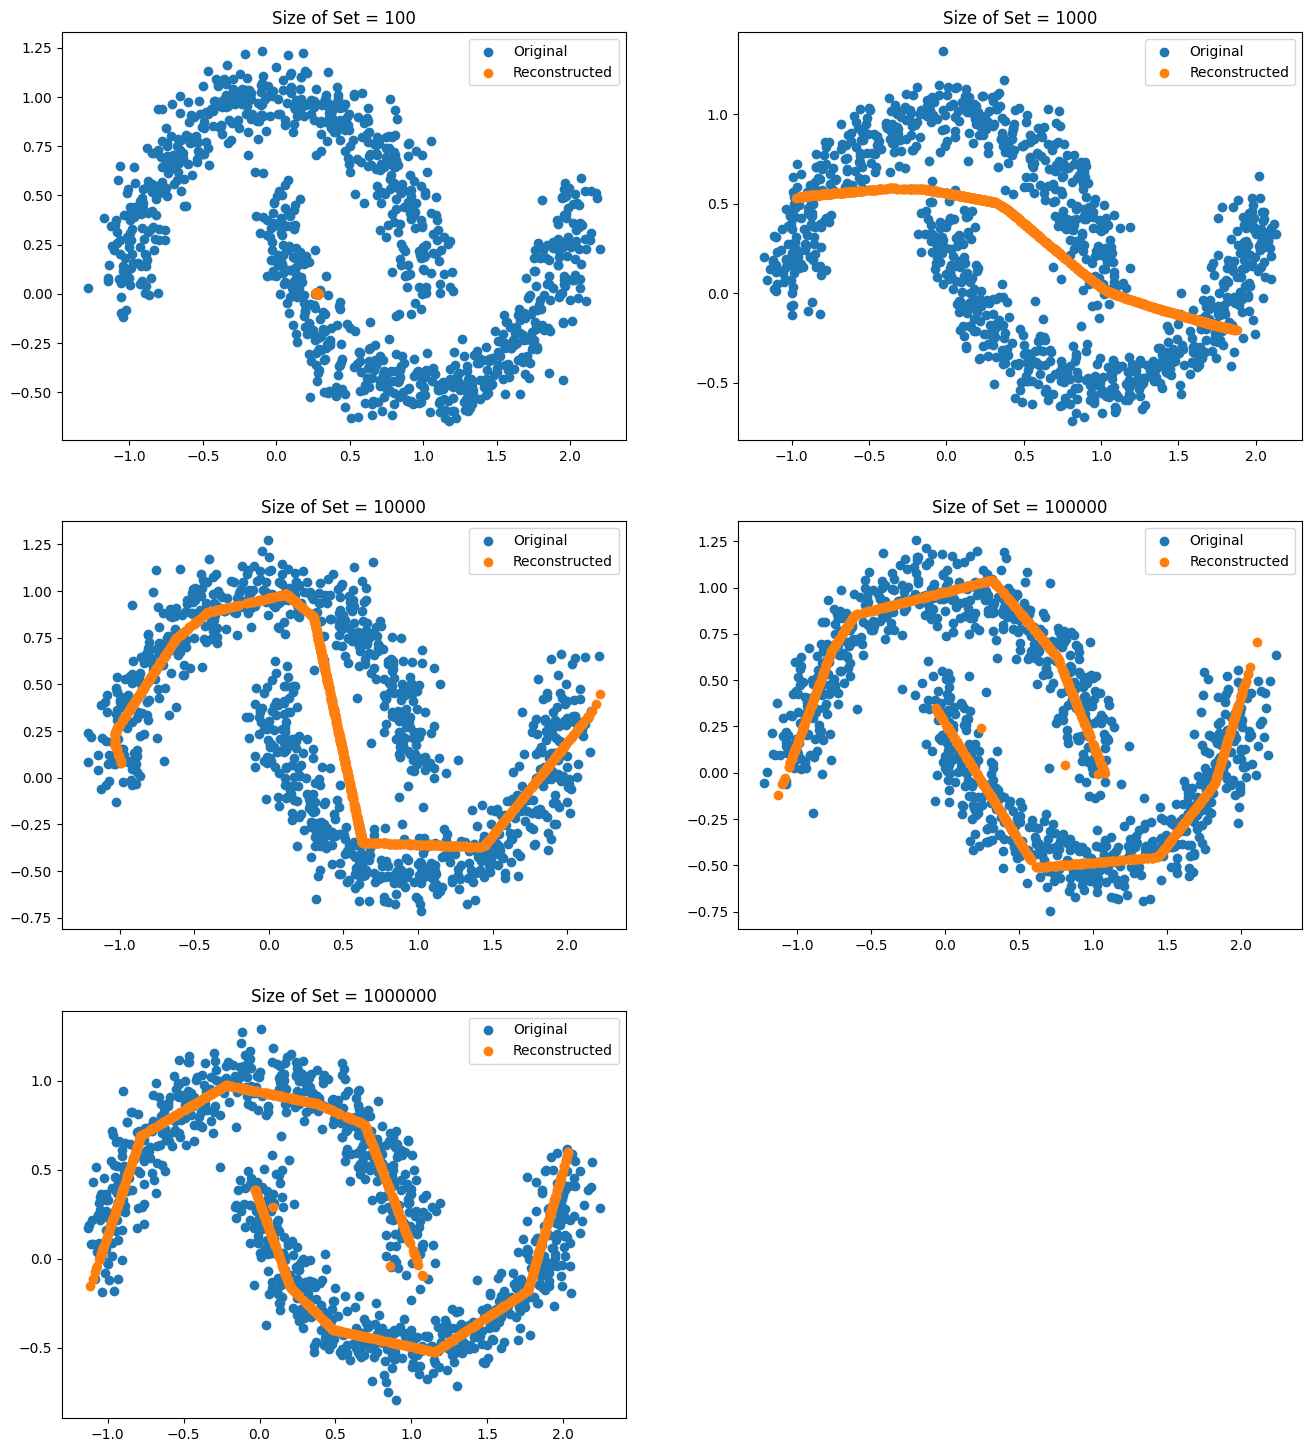

In [103]:
train_range = np.linspace(0, 50, 51)
test_range = np.linspace(0, 50, 6)

plt.figure(figsize=(16, 6))
for i in range(len(training_size_)):
    plt.subplot(1, 2, 1)
    plt.plot(train_range, training_size_results[i,:][0], label = f"Size of Set = {training_size_[i]}")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.grid()

for i in range(len(training_size_)):
    plt.subplot(1, 2, 2)
    plt.plot(test_range, training_size_results[i,:][1], label = f"Size of Set = {training_size_[i]}")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test loss")
plt.grid()
plt.show()

plt.figure(figsize=(16, 18))
for i, size in enumerate(training_size_):
    plt.subplot(3, 2, i + 1)
    plt.scatter(training_size_results[i,:][2][-1][:,0], training_size_results[i,:][2][-1][:,1], label = "Original")
    plt.scatter(training_size_results[i,:][3][-1][:,0], training_size_results[i,:][3][-1][:,1], label = f"Reconstructed")
    plt.title(f"Size of Set = {size}")
    plt.legend()

The size of the training set improves the speed of convergence of the training. Moreover, larger training sets clearly lead to much better results.

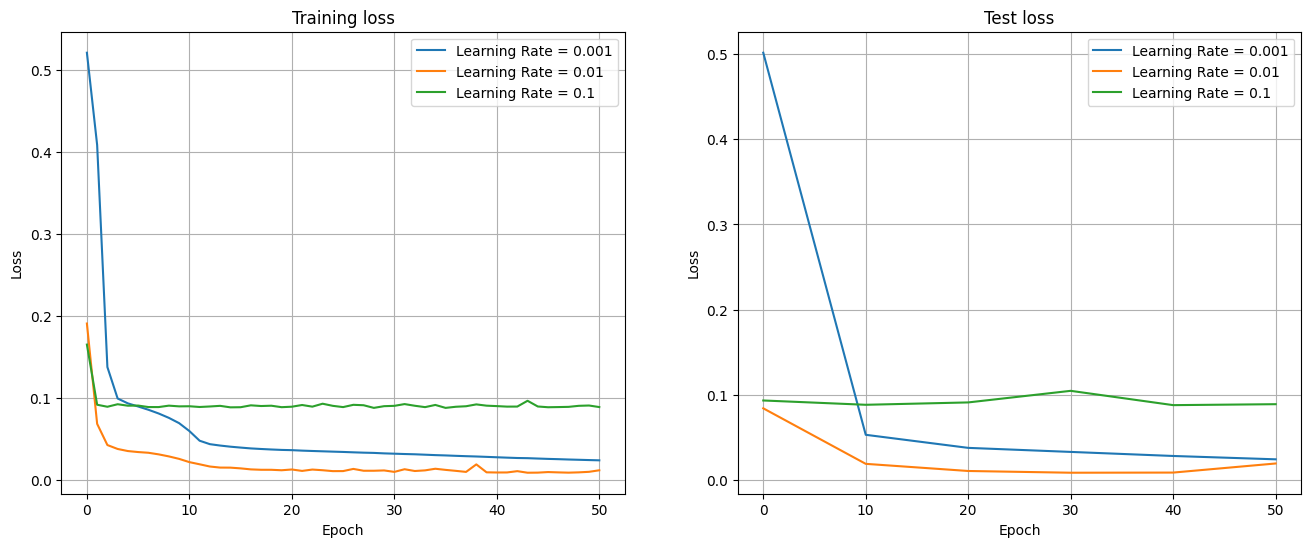

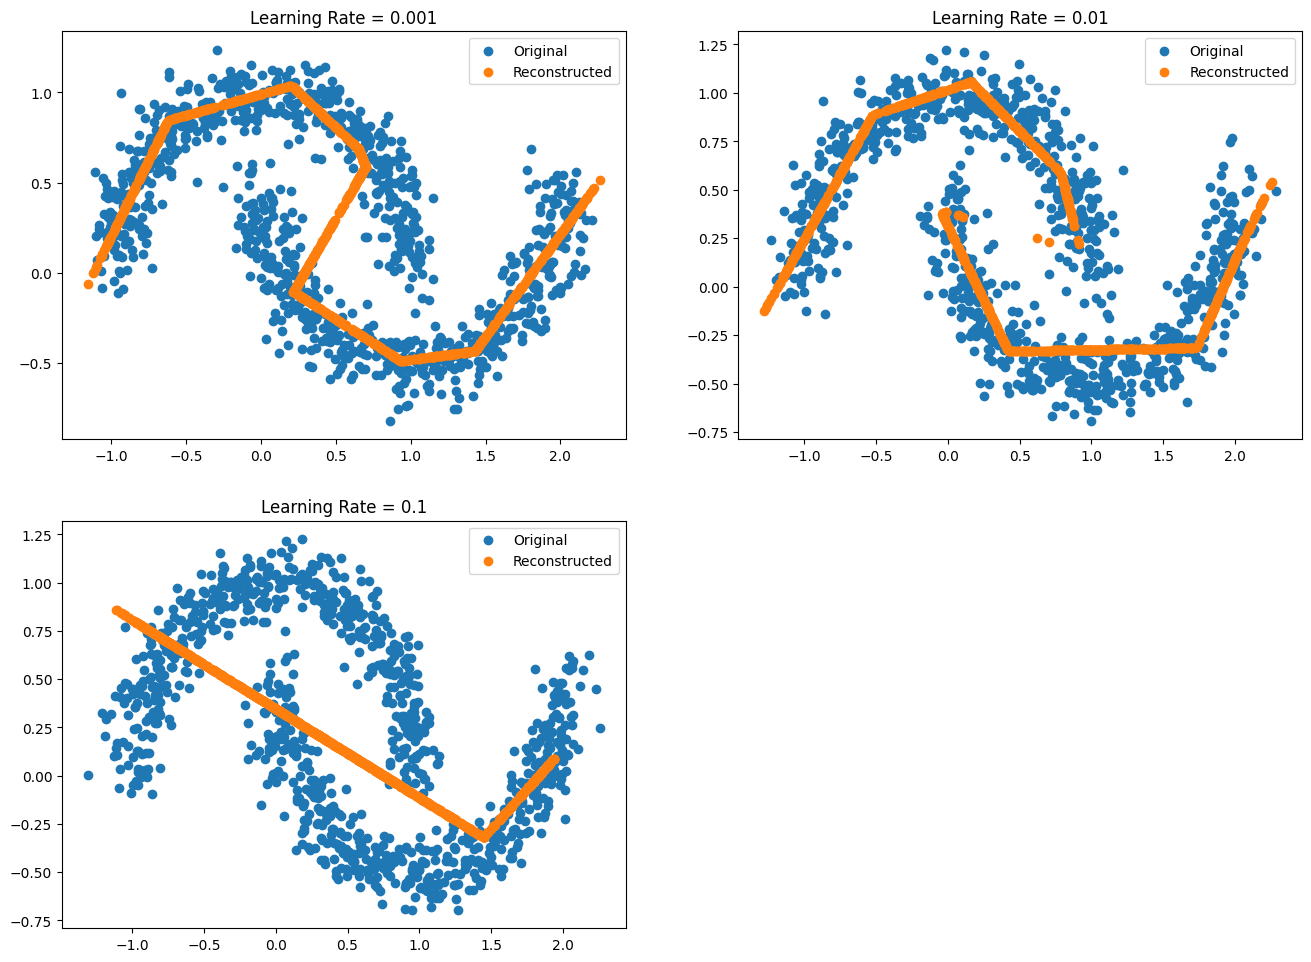

In [104]:
train_range = np.linspace(0, 50, 51)
test_range = np.linspace(0, 50, 6)

plt.figure(figsize=(16, 6))
for i in range(len(lr_)):
    plt.subplot(1, 2, 1)
    plt.plot(train_range, lr_results[i,:][0], label = f"Learning Rate = {lr_[i]}")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.grid()

for i in range(len(lr_)):
    plt.subplot(1, 2, 2)
    plt.plot(test_range, lr_results[i,:][1], label = f"Learning Rate = {lr_[i]}")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test loss")
plt.grid()
plt.show()

plt.figure(figsize=(16, 18))
for i, size in enumerate(lr_):
    plt.subplot(3, 2, i + 1)
    plt.scatter(lr_results[i,:][2][-1][:,0], lr_results[i,:][2][-1][:,1], label = "Original")
    plt.scatter(lr_results[i,:][3][-1][:,0], lr_results[i,:][3][-1][:,1], label = f"Reconstructed")
    plt.title(f"Learning Rate = {size}")
    plt.legend()

A medium learning rate of tau = 0.01 seems to be optimal. Larger learning rates lead to poor results as they are unable to find a good local optimum.

## 1.3 Variation of reconstruction

In [135]:
random_reconstruction = []
for i in range(10):
    opt_model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=8, layers=6)
    _, loss, _, _ = train_autoencoder(opt_model, training_size=100000, epochs=50, lr=0.001)
    random_reconstruction.append(loss[-1])

Epoch 0
Mean Train Loss 2.03e-01
Mean Test Loss 5.22e-02
Epoch 10
Mean Train Loss 1.05e-02
Mean Test Loss 1.10e-02
Epoch 20
Mean Train Loss 8.41e-03
Mean Test Loss 8.98e-03
Epoch 30
Mean Train Loss 8.03e-03
Mean Test Loss 8.70e-03
Epoch 40
Mean Train Loss 7.99e-03
Mean Test Loss 8.61e-03
Epoch 50
Mean Train Loss 7.01e-03
Mean Test Loss 6.95e-03
Epoch 0
Mean Train Loss 1.87e-01
Mean Test Loss 4.95e-02
Epoch 10
Mean Train Loss 1.70e-02
Mean Test Loss 1.54e-02
Epoch 20
Mean Train Loss 9.69e-03
Mean Test Loss 8.79e-03
Epoch 30
Mean Train Loss 6.72e-03
Mean Test Loss 6.20e-03
Epoch 40
Mean Train Loss 9.78e-03
Mean Test Loss 7.90e-03
Epoch 50
Mean Train Loss 7.57e-03
Mean Test Loss 1.38e-02
Epoch 0
Mean Train Loss 5.11e-01
Mean Test Loss 5.09e-01
Epoch 10
Mean Train Loss 5.07e-01
Mean Test Loss 5.09e-01
Epoch 20
Mean Train Loss 5.07e-01
Mean Test Loss 5.09e-01
Epoch 30
Mean Train Loss 5.07e-01
Mean Test Loss 5.09e-01
Epoch 40
Mean Train Loss 5.07e-01
Mean Test Loss 5.09e-01
Epoch 50
Mean Tra

In [136]:
same_reconstruction = []
for i in range(10):
    opt_model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=8, layers=6)
    _, loss, _, _ = train_autoencoder(opt_model, training_size=100000, epochs=50, lr=0.001, seed = 0)

    same_reconstruction.append(loss[-1])

Epoch 0
Mean Train Loss 2.31e-01
Mean Test Loss 6.09e-02
Epoch 10
Mean Train Loss 1.01e-02
Mean Test Loss 9.93e-03
Epoch 20
Mean Train Loss 6.42e-03
Mean Test Loss 7.56e-03
Epoch 30
Mean Train Loss 7.79e-03
Mean Test Loss 7.42e-03
Epoch 40
Mean Train Loss 6.14e-03
Mean Test Loss 6.39e-03
Epoch 50
Mean Train Loss 6.26e-03
Mean Test Loss 6.36e-03
Epoch 0
Mean Train Loss 2.04e-01
Mean Test Loss 7.90e-02
Epoch 10
Mean Train Loss 1.41e-02
Mean Test Loss 1.48e-02
Epoch 20
Mean Train Loss 1.07e-02
Mean Test Loss 1.08e-02
Epoch 30
Mean Train Loss 1.22e-02
Mean Test Loss 1.33e-02
Epoch 40
Mean Train Loss 9.41e-03
Mean Test Loss 8.40e-03
Epoch 50
Mean Train Loss 9.82e-03
Mean Test Loss 9.48e-03
Epoch 0
Mean Train Loss 2.27e-01
Mean Test Loss 6.17e-02
Epoch 10
Mean Train Loss 2.13e-02
Mean Test Loss 2.46e-02
Epoch 20
Mean Train Loss 1.42e-02
Mean Test Loss 1.43e-02
Epoch 30
Mean Train Loss 1.16e-02
Mean Test Loss 1.12e-02
Epoch 40
Mean Train Loss 9.58e-03
Mean Test Loss 9.13e-03
Epoch 50
Mean Tra

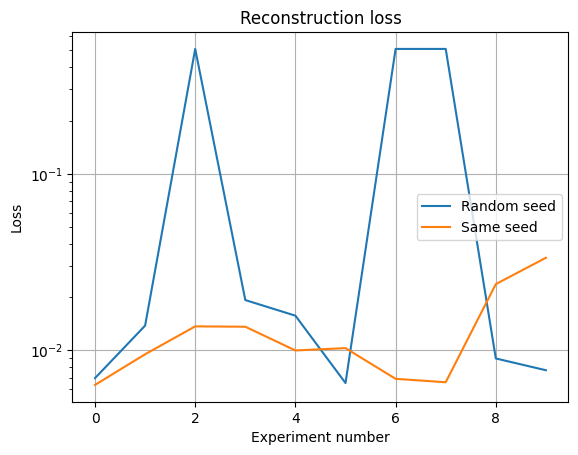

In [137]:
plt.plot(range(10), random_reconstruction, label = "Random seed")
plt.plot(range(10), same_reconstruction, label = "Same seed")
plt.xlabel("Experiment number")
plt.ylabel("Loss")
plt.title("Reconstruction loss")
plt.legend()
plt.grid()
plt.yscale("log")
plt.show()

## 1.4 Distribution of code

In [ ]:
opt_model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=8, layers=6)
_, _, _, _ = train_autoencoder(opt_model, training_size=500000, epochs=100, lr=0.001)

Epoch 0
Mean Train Loss 2.60e-01
Mean Test Loss 6.73e-02
Epoch 10
Mean Train Loss 1.04e-02
Mean Test Loss 1.06e-02
Epoch 20
Mean Train Loss 8.56e-03
Mean Test Loss 8.27e-03
Epoch 30
Mean Train Loss 7.41e-03
Mean Test Loss 7.97e-03
Epoch 40
Mean Train Loss 6.84e-03
Mean Test Loss 6.11e-03
Epoch 50
Mean Train Loss 7.09e-03
Mean Test Loss 7.53e-03
Epoch 60
Mean Train Loss 6.71e-03
Mean Test Loss 6.36e-03
Epoch 70
Mean Train Loss 6.41e-03
Mean Test Loss 6.02e-03
Epoch 80
Mean Train Loss 6.55e-03
Mean Test Loss 6.54e-03
Epoch 90
Mean Train Loss 6.85e-03
Mean Test Loss 7.59e-03
Epoch 100
Mean Train Loss 6.91e-03
Mean Test Loss 6.40e-03


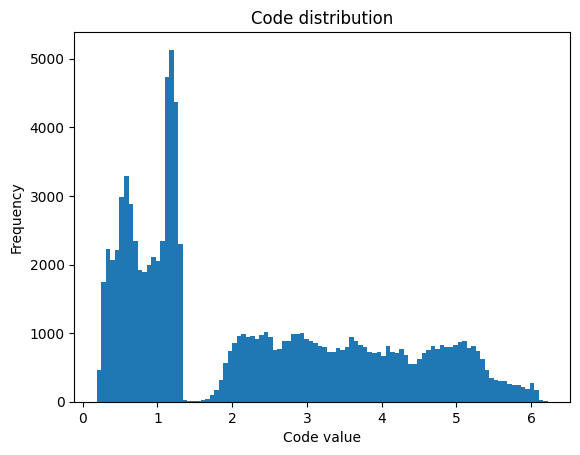

In [30]:
code_dist = opt_model.return_code(torch.tensor(generate_moons(100000)).float()).detach().numpy()
plt.hist(code_dist, bins = 100)
plt.xlabel("Code value")
plt.ylabel("Frequency")
plt.title("Code distribution")
plt.show()

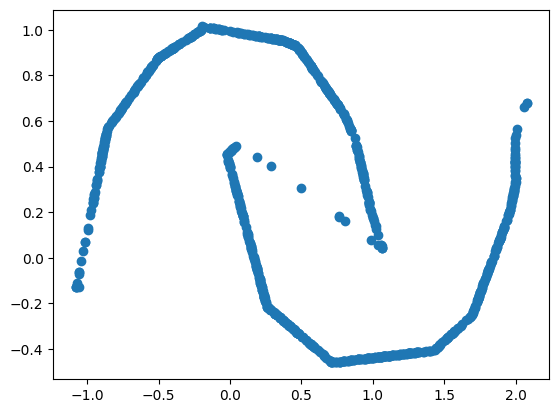

In [32]:
gmm = GaussianMixture(n_components=5)
gmm.fit(code_dist)
generate_latent = gmm.sample(1000)[0]
generate_points = opt_model.generate(torch.tensor(generate_latent).float()).detach().numpy()
plt.scatter(generate_points[:,0], generate_points[:,1])

## 1.5 Noise level 0.2 without retraining

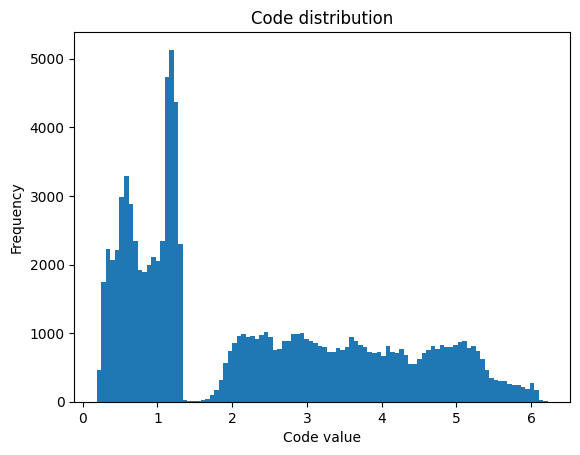

In [37]:
code_dist_double_noise = opt_model.return_code(torch.tensor(generate_moons(100000, noise = 0.2)).float()).detach().numpy()
plt.hist(code_dist, bins = 100)
plt.xlabel("Code value")
plt.ylabel("Frequency")
plt.title("Code distribution")
plt.show()

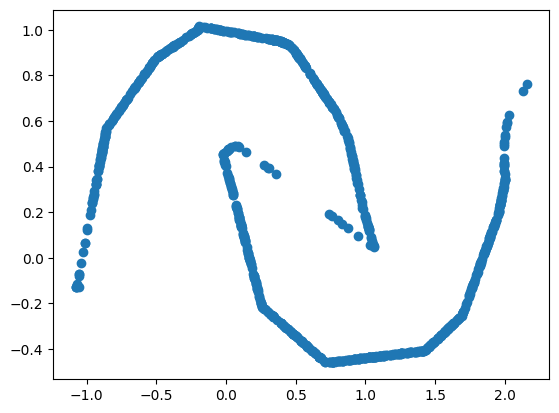

In [38]:
gmm = GaussianMixture(n_components=5)
gmm.fit(code_dist_double_noise)
generate_latent_double_noise = gmm.sample(1000)[0]
generate_points_double_noise = opt_model.generate(torch.tensor(generate_latent_double_noise).float()).detach().numpy()
plt.scatter(generate_points_double_noise[:,0], generate_points_double_noise[:,1])